<a href="https://colab.research.google.com/github/chloemaybrandon/UCLA_CS_M146/blob/main/CS146_Winter2025_Problem_Set_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

# Setup

In [ ]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###

sys.path += ['/content/drive/My Drive/UCLA/Winter_2025/CM146_ML/pset1']
# Both are in the same directory so I think this is OK
# sys.path += ['/content/drive/']

In [ ]:
from nutil import *

In [ ]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# Models

In [ ]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [ ]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set

        unique, counts = np.unique(y, return_counts=True)  # Get unique classes and their counts
        total_samples = len(y)

        # Store probabilities as a dictionary {class_label: probability}
        self.probabilities_ = {cls: count / total_samples for cls, count in zip(unique, counts)}

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)

        classes = np.array(list(self.probabilities_.keys()))
        probabilities = np.array(list(self.probabilities_.values()))

        # Generate random predictions using np.random.choice
        y = np.random.choice(classes, size=X.shape[0], p=probabilities)

        ### ========== TODO : END ========== ###

        return y


# Auxiliary functions

In [ ]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels

In [ ]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials



    ### ========== TODO : END ========== ###

    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)  # ✅ Correct

    train_errors = []
    test_errors = []
    f1_scores = []

    for train_idx, test_idx in sss.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train the classifier
        clf.fit(X_train, y_train)

        # Predictions
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        # Compute errors and F1 score
        train_errors.append(1 - accuracy_score(y_train, y_train_pred))
        test_errors.append(1 - accuracy_score(y_test, y_test_pred))
        f1_scores.append(f1_score(y_test, y_test_pred, average='micro'))

    # Compute mean values
    avg_train_error = np.mean(train_errors)
    avg_test_error = np.mean(test_errors)
    avg_f1_score = np.mean(f1_scores)

    return avg_train_error, avg_test_error, avg_f1_score

    # return train_error, test_error, f1_score

In [ ]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()

# Evaluation

Plotting...


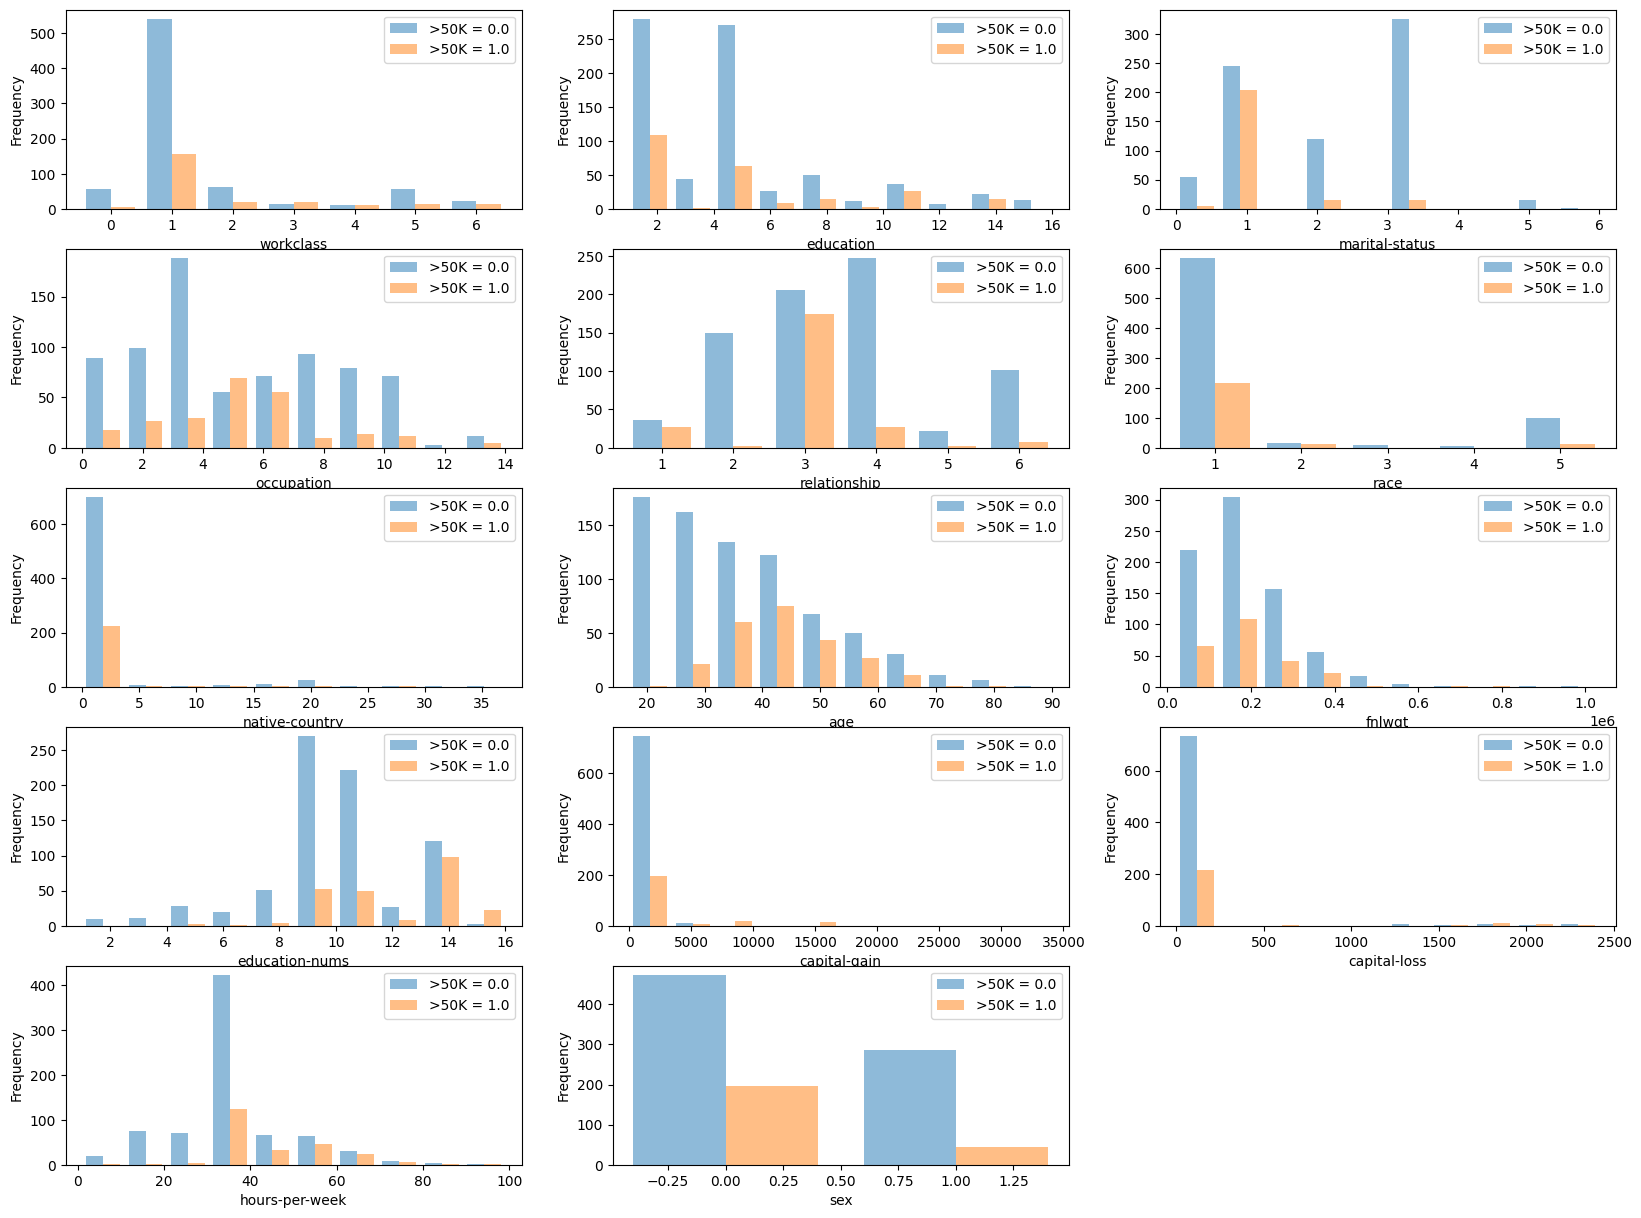

Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- training error (k=3): 0.114
	-- training error (k=5): 0.129
	-- training error (k=7): 0.152
Investigating various classifiers...
Compute Majority vote:
	-- training error: 0.240
	-- test error: 0.240
	-- test F1 score: 0.760

Compute Random:
	-- training error: 0.375
	-- test error: 0.382
	-- test F1 score: 0.618

Compute Decision tree:
	-- training error: 0.000
	-- test error: 0.204
	-- test F1 score: 0.796

Compute KNN using k=5:
	-- training error: 0.133
	-- test error: 0.209
	-- test F1 score: 0.791

Finding the best k...


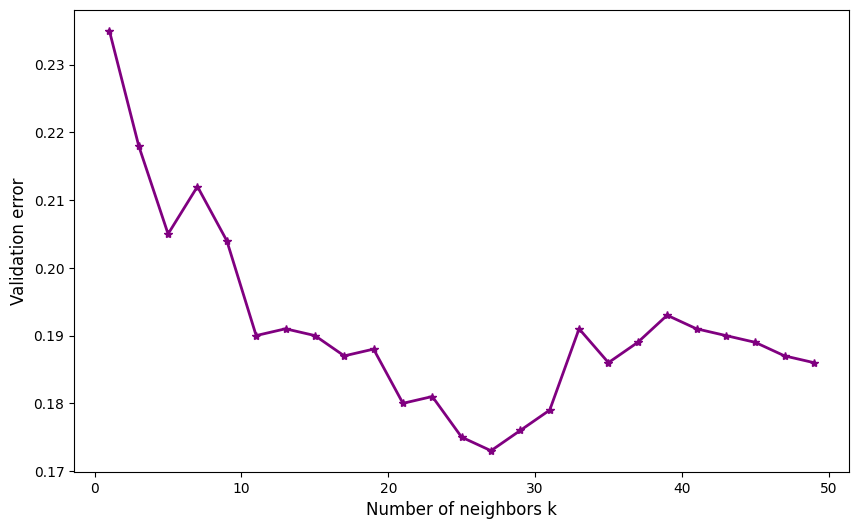

The best value of k is 27
Investigating depths...


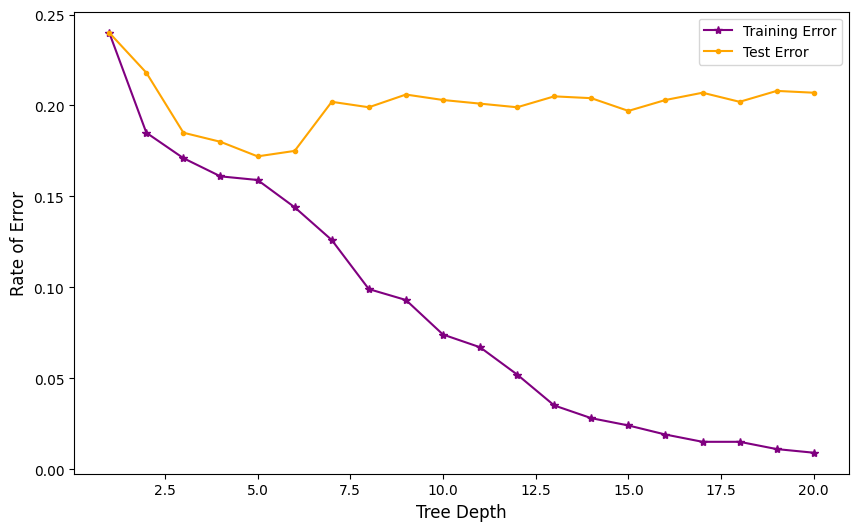

The best depth limit for this dataset is 5
Investigating Learning Curves...


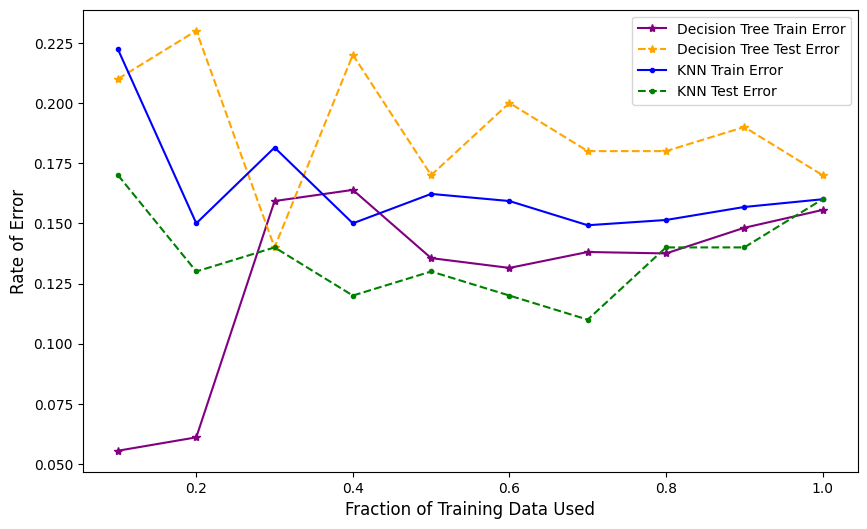

Done


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

######################################################################
# main
######################################################################

def main():
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/My Drive/UCLA/Winter_2025/CM146_ML/pset1/adult_subsample.csv"
    ### ========== TODO : END ========== ###


    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features




    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    plt.show()



    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    # (try this after finishing the sections below)

    from sklearn.preprocessing import StandardScaler

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Fit on the entire dataset and transform
    X = scaler.fit_transform(X)

    # X = ?

    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    clf = RandomClassifier ()

    clf.fit(X, y)  # Train on dataset
    y_pred = clf.predict(X)  # Generate predictions

    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)  # Compute training error

    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')

    clf = DecisionTreeClassifier(criterion='entropy', random_state=1234)  # Use 'entropy' for information gain
    clf.fit(X, y)  # Train the model
    y_pred = clf.predict(X)  # Predict on training data

    train_error = 1 - metrics.accuracy_score(y, y_pred)  # Compute training error

    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')


    # print the error for each k

        # Train and evaluate KNeighborsClassifier for k = 3, 5, 7
    for k in [3, 5, 7]:

        clf = KNeighborsClassifier(n_neighbors=k)  # Initialize KNN with k neighbors
        clf.fit(X, y)  # Train the model
        y_pred = clf.predict(X)  # Predict on training data

        train_error = 1 - metrics.accuracy_score(y, y_pred)  # Compute training error
        print(f'\t-- training error (k={k}): {train_error:.3f}')



    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    # clf =

    # summary = error(clf, X, y, ntrials=20)
    # print(summary)

    # Initialize classifiers
    majority_clf = MajorityVoteClassifier()
    random_clf = RandomClassifier()
    dt_clf = DecisionTreeClassifier(criterion='entropy', random_state=1234)
    knn_clf = KNeighborsClassifier(n_neighbors=5)

    # Compute errors for each classifier
    for clf, name in zip([majority_clf, random_clf, dt_clf, knn_clf], ["Majority vote", "Random", "Decision tree", "KNN using k=5"]):
        print(f"Compute {name}:")
        train_err, test_err, f1 = error(clf, X, y)
        print(f"\t-- training error: {train_err:.3f}")
        print(f"\t-- test error: {test_err:.3f}")
        print(f"\t-- test F1 score: {f1:.3f}\n")
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')

    # Range of odd k values from 1 to 50
    k_values = list(range(1, 51, 2))

    # Store validation errors
    validation_errors = []

    # Perform 10-fold cross-validation for each k
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k)
        # Use cross_val_score to perform 10-fold cross-validation and calculate accuracy
        scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
        validation_errors.append(1 - np.mean(scores))  # Convert accuracy to error

    # Plot the validation error against the number of neighbors (k)
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, validation_errors, marker='*', color='purple', linestyle='-', linewidth=2, markersize=6)
    plt.xlabel('Number of neighbors k', fontsize=12)
    plt.ylabel('Validation error', fontsize=12)
    plt.grid(False)
    plt.show()

    # Print the best value of k
    best_k = k_values[np.argmin(validation_errors)]
    print(f"The best value of k is {best_k}")

    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')

    # Define depth range
    depth_values = list(range(1, 21))

    # Store training and test errors
    train_errors = []
    test_errors = []

    # Loop over different depth limits
    for depth in depth_values:
        clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=1234)

        # Compute test accuracy using cross-validation
        test_scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')  # 10-fold cross-validation



        clf.fit(X, y)
        train_accuracy = accuracy_score(y, clf.predict(X))





        train_errors.append(1 - train_accuracy)
        test_errors.append(1 - np.mean(test_scores))




    # Plot training and test errors
    plt.figure(figsize=(10, 6))
    plt.plot(depth_values, train_errors, label="Training Error", marker='*', linestyle='-', color='purple')
    plt.plot(depth_values, test_errors, label="Test Error", marker='.', linestyle='-', color='orange')
    plt.xlabel("Tree Depth", fontsize=12)
    plt.ylabel("Rate of Error", fontsize=12)
    plt.legend()
    plt.grid(False)
    plt.show()

    # Find the best depth (min test error)
    best_depth = depth_values[np.argmin(test_errors)]
    print(f"The best depth limit for this dataset is {best_depth}")

    ### ========== TODO : END ========== ###



    from sklearn.model_selection import train_test_split

    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    # hint: use train_test_split (use random_state=0 for consistent results)

    print("Investigating Learning Curves...")

    # Best hyperparameters from earlier parts
    best_depth = 5  # Replace with actual best depth from part g
    best_k = 9  # Replace with actual best k from part f

    # Split data (90% training, 10% testing)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    # Training sizes from 10% to 100% of the 90% fraction
    train_sizes = np.linspace(0.1, 1.0, 10)

    # Store errors
    dt_train_errors, dt_test_errors = [], []
    knn_train_errors, knn_test_errors = [], []

    for frac in train_sizes:
        # Take subset of training data
        if frac < 1.0:
            X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=frac, random_state=0)
        else:
            X_train, y_train = X_train_full, y_train_full  # Use the full dataset

        # Decision Tree
        dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=best_depth, random_state=1234)
        dt_clf.fit(X_train, y_train)

        dt_train_error = 1 - accuracy_score(y_train, dt_clf.predict(X_train))
        dt_test_error = 1 - accuracy_score(y_test, dt_clf.predict(X_test))

        dt_train_errors.append(dt_train_error)
        dt_test_errors.append(dt_test_error)

        # K-Nearest Neighbors
        knn_clf = KNeighborsClassifier(n_neighbors=best_k)
        knn_clf.fit(X_train, y_train)

        knn_train_error = 1 - accuracy_score(y_train, knn_clf.predict(X_train))
        knn_test_error = 1 - accuracy_score(y_test, knn_clf.predict(X_test))

        knn_train_errors.append(knn_train_error)
        knn_test_errors.append(knn_test_error)

    # Plot learning curves
    plt.figure(figsize=(10, 6))

    # Decision Tree Plot
    plt.plot(train_sizes, dt_train_errors, label="Decision Tree Train Error", marker='*', linestyle='-', color='purple')
    plt.plot(train_sizes, dt_test_errors, label="Decision Tree Test Error", marker='*', linestyle='--', color='orange')

    # KNN Plot
    plt.plot(train_sizes, knn_train_errors, label="KNN Train Error", marker='.', linestyle='-', color='blue')
    plt.plot(train_sizes, knn_test_errors, label="KNN Test Error", marker='.', linestyle='--', color='green')

    plt.xlabel("Fraction of Training Data Used", fontsize=12)
    plt.ylabel("Rate of Error", fontsize=12)
    plt.legend()
    plt.grid(False)
    plt.show()

    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
